<a href="https://colab.research.google.com/github/vpagonis/EURADOS-2023/blob/main/Fitting_experimental_data_with_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fitting experimental data with Python

In many of the Python codes we use the package `optimize` in Python to perform CGCD analysis of TL glow curves. Specifically we will import and use the function `curve_fit()`:

`params,cov=scipy.optimize.curve_fit(f,xdata,ydata,p0,bounds)`

Here `f` is the analytical function which is used to fit the data `(xdata,ydata)`. The array `p0` contains the initial guesses for the parameters, and the option `bounds` specifies the lower and upper bounds on the parameters 

`bounds=(lowerbounds,higherbounds)`

There are two components in the output of the `curve_fit()` function, `params` and `cov` . The first component is the array `params` which contains the optimal values for the parameters, so that the sum of the squared residuals evaluated from

`f(xdata,*params)-ydata`

is minimized. Here `*params` is used to pass the array of fitting parameters obtained in the `optimize.curve_fit()` function. 

The second parameter in the output of the `curve_fit()` function is `cov`, which is a 2-D array containing the estimated covariance of the best fit parameters `params`. The diagonal elements of `cov` provide the variance \sigma^{2} of the best fit estimates for the parameters, and are evaluated using the Python command `diag.(cov)`. In order to compute one standard deviation uncertainties (1\sigma) of the parameters, instead of the variance \sigma^{2}, we evaluate the array `np.sqrt(np.diag(cov)`. 

In the Python codes, the residuals are calculated using the difference

`f(xdata,*params)-ydata`

The quantity minimized is the sum of the squared residuals `f` for unweighted data. 

The TL equation for First Order Kinetics (FOK-TL) is:

\begin{equation}
I_{TL}(T)=A\exp\left[-\frac{E}{k\,T}\right]\;\exp\left\{ -\frac{s\:k\:T^{2}}{\beta\:E}\,\exp\left[-\frac{E}{k\,T}\right]\;\left(1-\frac{2kT}{E}\right)\right\} 
\end{equation}

where $A$ is a constant, $s$  is the frequency factor (in s$^{-1}$),  $E$ is the activation energy (in eV), $k$  is the Boltzmann constant, and $\beta$  is the heating rate (in K/s).

The three independent fitting parameters in this CGCD equations are $E$ (eV), the scaling factor $A$ and the frequency factor s (s$^{-1}$).

Here is an example of Code 3.1, which implements the FOK-TL equation for CGCD analysis. The code imports and uses the package `optimize` and the function `curve_fit()` from the  `SciPy` Python library. The function `PrettyTable()` from the package `prettytable` is used for formatting and printing the results of the least squares fit in a Table format. 
The figure below the code shows the deconvoluted Reference glow curve #1 from the GLOCANIN project  (Bos et al. [#Bos1993d]). This simulated data was normalized by dividing with the maximum TL intensity, in order to assist the least squares fitting routine in reaching a minimum. The starting values $A,s,E$ for the least squares fitting procedure are contained in the parameter `inis`.

The best fit activation energy is E=$\left(1.183\pm3\times10^{-6}\right)$ eV, which is within $\sim0.08%$ of the expected value of E=1.182 eV. The FOM=0.003 %, indicating an excellent fit to this simulated TL peak. The rest of the best fit parameters are s=9.8$\times10^{10} s^{-1}$ , A=3.6$\times10^{12}$ a.u. The original frequency factor value used in the paper by Bos et al. [#Bos1993d] for this simulated glow curve is $s=8.05\times10^{10} s^{-1}$, which is very close to the best fit value of s.

The residuals $y_{i}^{expt}-y_{i}^{fit}$ of the best fit are calculated and plotted underneath the data.

FOM= 0.003  %
+------------+------------+------------+-------+-------+
|     A      |  s (s^-1)  |     ds     | E(eV) |   dE  |
+------------+------------+------------+-------+-------+
|    3.6E+12 |    9.8E+10 |    7.6E+06 | 1.183 | 3e-06 |
+------------+------------+------------+-------+-------+


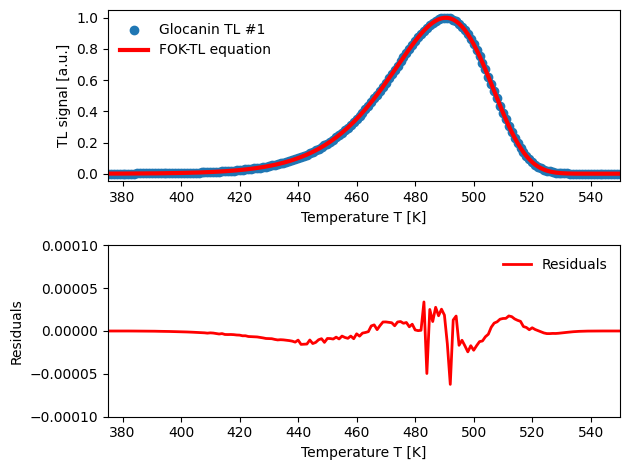

In [ ]:
# Deconvolution of Glocanin TL with the original FOK-TL equation
import numpy as np
import matplotlib.pyplot as plt
import requests
import warnings
warnings.filterwarnings("ignore")
from scipy import optimize
from prettytable import PrettyTable 
# read data file from GitHub
url='https://github.com/vpagonis/EURADOS-2023/raw/main/glocanin1.TXT'
response=requests.get(url)
a=response.text
b=np.array(list(map(float,a.strip("[]").split())))
data=b.reshape(-1,2)

x_data,y_data = data[:, 0], data[:, 1] 
y_data=y_data/max(y_data)

kB,  beta= 8.617e-5,  1
# function for evaluating the FOK-TL (R-W) equation
def TLFOK(T,A,s,E):    
    expint=kB*(T**2.0)/(beta*E)*\
	    np.exp(-E/(kB*T))*(1-2*kB*T)/E
    return A*np.exp(-E/(kB*T))*np.exp(-(s/beta)*expint) 
inis=([1e15,1e10,1])  # starting values (A, s, E) for the fit
# find optimal parameters 
params, cov=optimize.curve_fit(TLFOK,x_data,y_data,inis)
# params are the best fit values for the parameters 
# cov is the covariance of the best fit parameters 
plt.subplot(2,1, 1);  
plt.scatter(x_data, y_data, label='Glocanin TL #1');
plt.plot(x_data, TLFOK(x_data, *params),
c='r',linewidth=3, label='FOK-TL equation'); 
leg = plt.legend()
leg.get_frame().set_linewidth(0.0)
plt.ylabel('TL signal [a.u.]');
plt.xlabel(r'Temperature T [K]');
plt.xlim(375,550);
plt.subplot(2,1, 2); 
plt.plot(x_data,TLFOK(x_data, *params)-\
y_data,c='r',linewidth=2,label='Residuals');
leg = plt.legend()
leg.get_frame().set_linewidth(0.0)
plt.ylabel('Residuals');
plt.xlabel(r'Temperature T [K]');
plt.xlim(375,550);
plt.ylim(-0.0001,.0001);
plt.tight_layout()
A=format(params[0],"10.1E")
dA = format(np.sqrt(cov[0][0]),"10.1E")
s=format(params[1],"10.1E")
ds = format(np.sqrt(cov[1][1]),"10.1E")
E=round(params[2],3)
dE = round(np.sqrt(cov[2][2]),7)
res=TLFOK(x_data, *params)-y_data
FOM=round(100*np.sum(abs(res))/np.sum(y_data),3)
myTable = PrettyTable([ "A","s (s^-1)","ds","E(eV)","dE"]) 
myTable.add_row([A,s,ds,E,dE]);
print('FOM=',FOM, ' %')
print(myTable)
plt.show()